In [1]:
import torch
import torchvision
from torchvision import transforms

c:\Users\Pawel\anaconda3\envs\env_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_PATH = './knee-osteoarthritis'

In [3]:
TRAIN_PATH = f'{DATASET_PATH}/train'
VAL_PATH = f'{DATASET_PATH}/val'
TEST_PATH = f'{DATASET_PATH}/test'
AUTO_TEST_PATH = f'{DATASET_PATH}/auto_test'

In [4]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [5]:

train = torchvision.datasets.ImageFolder(TRAIN_PATH, TRANSFORM_IMG)
# val = torchvision.datasets.ImageFolder(VAL_PATH, TRANSFORM_IMG)
# test = torchvision.datasets.ImageFolder(TEST_PATH, TRANSFORM_IMG)
# auto_test = torchvision.datasets.ImageFolder(AUTO_TEST_PATH, TRANSFORM_IMG)

In [6]:
print(len(train))
# print(len(val))
# print(len(test))
# print(len(auto_test))

5778


### Building Dataset

In [7]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

class KneeOsteoarthritis(Dataset):
    def __init__(self, dataset):
        self.images = []
        self.labels = []
        
        for data in dataset:
            self.images.append(data[0])
            self.labels.append(data[1])
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        return image, label

In [8]:
train_dataset = KneeOsteoarthritis(train)
# val_dataset = KneeOsteoarthritis(val)
# test_dataset = KneeOsteoarthritis(test)
# auto_test_dataset = KneeOsteoarthritis(auto_test)

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


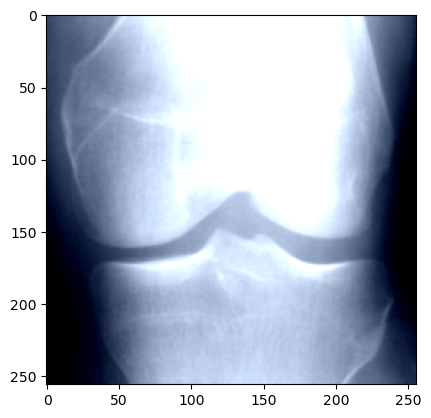

In [10]:
imshow(train_dataset[0][0])

### Augmentation 

In [11]:
import cv2

#### Edges

In [247]:
example_img = (train_dataset[0][0].numpy()*255).astype(np.uint8)
# img_path = './knee-osteoarthritis/train/0/9003658L.png'
img_path = "./knee-osteoarthritis/train/1/9994848R.png"
# img_path = "./knee-osteoarthritis/train/1/9996098R.png"
image = cv2.imread(img_path)

In [237]:
grayscaled = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# _, grayscaled = cv2.threshold(grayscaled, 100, 205, cv2.THRESH_TOZERO)

cv2.imwrite("./grayscaled.png", grayscaled)

True

In [242]:
sobel_y_1 = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
])
sobel_y_2 = sobel_y_1 * -1

# Apply two filters, upper and lower for different bones
edges_1 = cv2.filter2D(grayscaled, -1, sobel_y_1)
edges_2 = cv2.filter2D(grayscaled, -1, sobel_y_2)

# Cutout noisy background 
_, edges_1 = cv2.threshold(edges_1, 10, 255, cv2.THRESH_TOZERO)
_, edges_2 = cv2.threshold(edges_2, 10, 255, cv2.THRESH_TOZERO)

edges = edges_1 + edges_2

max_brightness = edges.max()
print(max_brightness)

# Normalize color
edges = cv2.convertScaleAbs(edges, alpha = 255/max_brightness, beta = 0)

# edges = cv2.Canny(edges, 300, 600)
cv2.imwrite("./preview_vertical.png", edges)

237


True

### Configuring loader

In [149]:
from collections import Counter

freq_table = dict(Counter(train_dataset.labels))
least_class_frequency = min(freq_table.values())

print(freq_table, least_class_frequency, list(freq_table.values()))

{0: 2286, 1: 3319, 2: 173} 173 [2286, 3319, 173]


In [150]:
class_sample_count = np.array(freq_table.values())
print(class_sample_count)
weights = np.zeros(len(train_dataset.labels))
for i, weight in enumerate(weights):
    label = train_dataset.labels[i]
    weights[i] = 1 / freq_table[label]
    
print(weights)
samples_weight = torch.from_numpy(weights)
samples_weigth = samples_weight.double()
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

dict_values([2286, 3319, 173])
[0.00043745 0.00043745 0.00043745 ... 0.00578035 0.00578035 0.00578035]


In [151]:
print(samples_weigth)

tensor([0.0004, 0.0004, 0.0004,  ..., 0.0058, 0.0058, 0.0058],
       dtype=torch.float64)


In [152]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, sampler=sampler)

### Building Model

In [243]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18, ResNet18_Weights

class AugmentedModel(nn.Module):
    def __init__(self, num_classes: int = 5, dropout: float = 0.5) -> None:
        super().__init__()
        
        weights = ResNet18_Weights.DEFAULT
        self.resnet18 = resnet18(weights=weights, progress=False)
        
        self.edgesClassifier = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(1000, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.resnet18(x)
        # print(x.shape)
        x = self.classifier(x)
        return x
      
net = AugmentedModel(3)
net = net.to(device)

In [156]:
sum(p.numel() for p in net.parameters())

32583211

### Training Model

In [157]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.classifier.parameters(), lr=0.001)

In [158]:
epoch_correct = 0
epoch_samples = 0
running_loss = 0.0
    
for epoch in range(50):  # loop over the dataset multiple times
    
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        # Changing outputs (logits) to labels
        outputs_clear = outputs.max(1).indices
        
        epoch_correct += (outputs_clear == labels).float().sum()
        epoch_samples += len(outputs)
        
        running_loss += loss.item()
            
    accuracy = epoch_correct / epoch_samples * 100
    print(f'Epoch {epoch + 1}: loss: {running_loss / epoch_samples:.3f}, accuracy: {accuracy}%')
    
    epoch_correct = 0
    epoch_samples = 0
    running_loss = 0.0

print('Finished Training')

KeyboardInterrupt: 